<a href="https://colab.research.google.com/github/claudeshyaka/Real-Time_Machine_Learning/blob/main/Transfomer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Claude Shyaka
## ID# 801362243
## Real-Time Machine Learning -- Transformers

In [1]:
# !pip install pip==21.3.1
!pip install -q d2l==1.0.0a1.post0
# !pip install -q d2l

%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.8 MB/s eta 0:00:00


In [2]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import time

## Machine Translation

In [3]:
class PositionWiseFFN(nn.Module):
  """The positionWise feed-forward network"""
  def __init__(self, ffn_num_hiddens, ffn_num_outputs):
    super().__init__()
    self.dense1 = nn.LazyLinear(ffn_num_hiddens)
    self.relu = nn.ReLU()
    self.dense2 = nn.LazyLinear(ffn_num_outputs)

  def forward(self, X):
    return self.dense2(self.relu(self.dense1(X)))

In [4]:
class AddNorm(nn.Module):
  """The residual connection followed by layer normalization."""
  def __init__(self, norm_shape, dropout):
    super().__init__()
    self.dropout = nn.Dropout(dropout)
    self.ln = nn.LayerNorm(norm_shape)

  def forward(self, X, Y):
    return self.ln(self.dropout(Y) + X)


### Encoder

In [5]:
class TransformerEncoderBlock(nn.Module):
  """The Transformer encoder block."""
  def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout,
                use_bias=False):
    super().__init__()
    self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                            dropout, use_bias)
    self.addnorm1 = AddNorm(num_hiddens, dropout)
    self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
    self.addnorm2 = AddNorm(num_hiddens, dropout)

  def forward(self, X, valid_lens):
    Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
    return self.addnorm2(Y, self.ffn(Y))



In [6]:
class TransformerEncoder(d2l.Encoder):
  """The Transformer encoder."""
  def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens,
                num_heads, num_blks, dropout, use_bias=False):
    super().__init__()
    self.num_hiddens = num_hiddens
    self.embedding = nn.Embedding(vocab_size, num_hiddens)
    self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
    self.blks = nn.Sequential()
    for i in range(num_blks):
        self.blks.add_module("block"+str(i), TransformerEncoderBlock(
            num_hiddens, ffn_num_hiddens, num_heads, dropout, use_bias))

  def forward(self, X, valid_lens):
    # Since positional encoding values are between -1 and 1, the embedding
    # values are multiplied by the square root of the embedding dimension
    # to rescale before they are summed up
    X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
    self.attention_weights = [None] * len(self.blks)
    for i, blk in enumerate(self.blks):
        X = blk(X, valid_lens)
        self.attention_weights[
            i] = blk.attention.attention.attention_weights
    return X


In [7]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = TransformerEncoderBlock(24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X, valid_lens), X.shape)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [8]:
encoder = TransformerEncoder(200, 24, 48, 8, 2, 0.5)
d2l.check_shape(encoder(torch.ones((2, 100), dtype=torch.long), valid_lens),
                (2, 100, 24))


### Decoder

In [9]:
class TransformerDecoderBlock(nn.Module):
  # The i-th block in the Transformer decoder
  def __init__(self, num_hiddens, ffn_num_hiddens, num_heads, dropout, i):
    super().__init__()
    self.i = i
    self.attention1 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                              dropout)
    self.addnorm1 = AddNorm(num_hiddens, dropout)
    self.attention2 = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                              dropout)
    self.addnorm2 = AddNorm(num_hiddens, dropout)
    self.ffn = PositionWiseFFN(ffn_num_hiddens, num_hiddens)
    self.addnorm3 = AddNorm(num_hiddens, dropout)

  def forward(self, X, state):
    enc_outputs, enc_valid_lens = state[0], state[1]
    # During training, all the tokens of any output sequence are processed
    # at the same time, so state[2][self.i] is None as initialized. When
    # decoding any output sequence token by token during prediction,
    # state[2][self.i] contains representations of the decoded output at
    # the i-th block up to the current time step
    if state[2][self.i] is None:
        key_values = X
    else:
        key_values = torch.cat((state[2][self.i], X), dim=1)
    state[2][self.i] = key_values
    if self.training:
        batch_size, num_steps, _ = X.shape
        # Shape of dec_valid_lens: (batch_size, num_steps), where every
        # row is [1, 2, ..., num_steps]
        dec_valid_lens = torch.arange(
            1, num_steps + 1, device=X.device).repeat(batch_size, 1)
    else:
        dec_valid_lens = None
    # Self-attention
    X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
    Y = self.addnorm1(X, X2)
    # Encoder-decoder attention. Shape of enc_outputs:
    # (batch_size, num_steps, num_hiddens)
    Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
    Z = self.addnorm2(Y, Y2)
    return self.addnorm3(Z, self.ffn(Z)), state


In [10]:
decoder_blk = TransformerDecoderBlock(24, 48, 8, 0.5, 0)
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
d2l.check_shape(decoder_blk(X, state)[0], X.shape)


In [11]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, num_hiddens, ffn_num_hiddens, num_heads,
                 num_blks, dropout):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_blks = num_blks
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module("block"+str(i), TransformerDecoderBlock(
                num_hiddens, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.LazyLinear(vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens):
        return [enc_outputs, enc_valid_lens, [None] * self.num_blks]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

### Training base case

42.80 sec


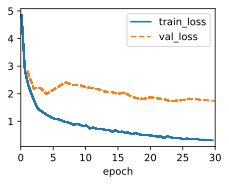

In [12]:
data = d2l.MTFraEng(batch_size=128)
num_hiddens, num_blks, dropout = 128, 2, 0.2
ffn_num_hiddens, num_heads = 64, 4
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.0015)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1, num_gpus=2)
tic = time.time()
trainer.fit(model, data)
print(f'{time.time() - tic:.2f} sec')

In [13]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
preds, _ = model.predict_step(
    data.build(engs, fras), d2l.try_gpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{d2l.bleu(" ".join(translation), fr, k=2):.3f}')


go . => ['va', '!'], bleu,1.000
i lost . => ['je', 'suis', '<unk>', '.'], bleu,0.000
he's calm . => ['il', 'est', 'venu', '.'], bleu,0.658
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000


In [14]:
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), d2l.try_gpu(), data.num_steps, True)
enc_attention_weights = torch.cat(model.encoder.attention_weights, 0)
shape = (num_blks, num_heads, -1, data.num_steps)
enc_attention_weights = enc_attention_weights.reshape(shape)
d2l.check_shape(enc_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))


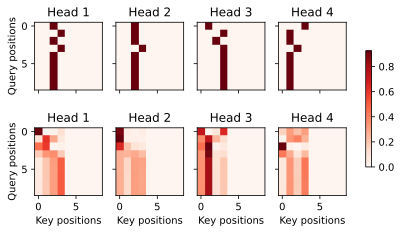

In [15]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))


In [16]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weights
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
shape = (-1, 2, num_blks, num_heads, data.num_steps)
dec_attention_weights = dec_attention_weights_filled.reshape(shape)
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)

d2l.check_shape(dec_self_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))
d2l.check_shape(dec_inter_attention_weights,
                (num_blks, num_heads, data.num_steps, data.num_steps))


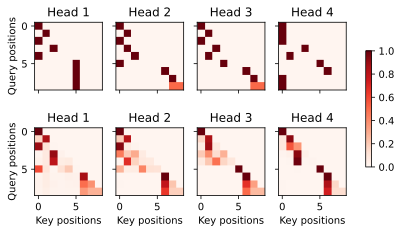

In [17]:
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))


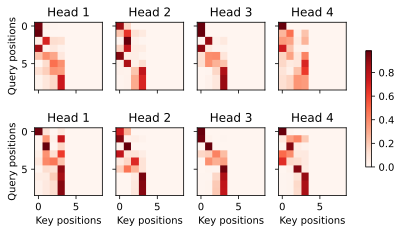

In [18]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))


### Training custom case

36.36 sec


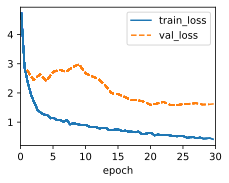

In [19]:
# Increasing number of blocks to 4.
num_hiddens, num_blks, dropout = 128, 2, 0.3
ffn_num_hiddens, num_heads = 256, 8
encoder = TransformerEncoder(
    len(data.src_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
decoder = TransformerDecoder(
    len(data.tgt_vocab), num_hiddens, ffn_num_hiddens, num_heads,
    num_blks, dropout)
modelCustom = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.0015)
tic = time.time()
trainer.fit(modelCustom, data)
print(f'{time.time() - tic:.2f} sec')

## Transformer for Vision

In [20]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=96, patch_size=16, num_hiddens=512):
        super().__init__()
        def _make_tuple(x):
            if not isinstance(x, (list, tuple)):
                return (x, x)
            return x
        img_size, patch_size = _make_tuple(img_size), _make_tuple(patch_size)
        self.num_patches = (img_size[0] // patch_size[0]) * (
            img_size[1] // patch_size[1])
        self.conv = nn.LazyConv2d(num_hiddens, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).flatten(2).transpose(1, 2)


In [21]:
img_size, patch_size, num_hiddens, batch_size = 96, 16, 512, 4
patch_emb = PatchEmbedding(img_size, patch_size, num_hiddens)
X = torch.zeros(batch_size, 3, img_size, img_size)
d2l.check_shape(patch_emb(X),
                (batch_size, (img_size//patch_size)**2, num_hiddens))


In [22]:
class ViTMLP(nn.Module):
    def __init__(self, mlp_num_hiddens, mlp_num_outputs, dropout=0.5):
        super().__init__()
        self.dense1 = nn.LazyLinear(mlp_num_hiddens)
        self.gelu = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.LazyLinear(mlp_num_outputs)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout2(self.dense2(self.dropout1(self.gelu(
            self.dense1(x)))))


In [23]:
class ViTBlock(nn.Module):
    def __init__(self, num_hiddens, norm_shape, mlp_num_hiddens,
                 num_heads, dropout, use_bias=False):
        super().__init__()
        self.ln1 = nn.LayerNorm(norm_shape)
        self.attention = d2l.MultiHeadAttention(num_hiddens, num_heads,
                                                dropout, use_bias)
        self.ln2 = nn.LayerNorm(norm_shape)
        self.mlp = ViTMLP(mlp_num_hiddens, num_hiddens, dropout)

    def forward(self, X, valid_lens=None):
        X = X + self.attention(*([self.ln1(X)] * 3), valid_lens)
        return X + self.mlp(self.ln2(X))


In [24]:
X = torch.ones((2, 100, 24))
encoder_blk = ViTBlock(24, 24, 48, 8, 0.5)
encoder_blk.eval()
d2l.check_shape(encoder_blk(X), X.shape)


In [25]:
class ViT(d2l.Classifier):
    """Vision Transformer."""
    def __init__(self, img_size, patch_size, num_hiddens, mlp_num_hiddens,
                 num_heads, num_blks, emb_dropout, blk_dropout, lr=0.1,
                 use_bias=False, num_classes=10):
        super().__init__()
        self.save_hyperparameters()
        self.patch_embedding = PatchEmbedding(
            img_size, patch_size, num_hiddens)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, num_hiddens))
        num_steps = self.patch_embedding.num_patches + 1  # Add the cls token
        # Positional embeddings are learnable
        self.pos_embedding = nn.Parameter(
            torch.randn(1, num_steps, num_hiddens))
        self.dropout = nn.Dropout(emb_dropout)
        self.blks = nn.Sequential()
        for i in range(num_blks):
            self.blks.add_module(f"{i}", ViTBlock(
                num_hiddens, num_hiddens, mlp_num_hiddens,
                num_heads, blk_dropout, use_bias))
        self.head = nn.Sequential(nn.LayerNorm(num_hiddens),
                                  nn.Linear(num_hiddens, num_classes))

    def forward(self, X):
        X = self.patch_embedding(X)
        X = torch.cat((self.cls_token.expand(X.shape[0], -1, -1), X), 1)
        X = self.dropout(X + self.pos_embedding)
        for blk in self.blks:
            X = blk(X)
        return self.head(X[:, 0])


### Training base case

279.10 sec


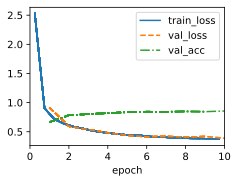

In [26]:
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 8, 2
emb_dropout, blk_dropout, lr = 0.1, 0.1, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=1)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
tic = time.time()
trainer.fit(model, data)
print(f'{time.time() - tic:.2f} sec')

### Training custom case

315.29 sec


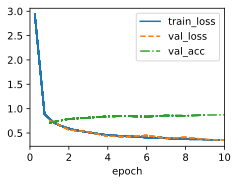

In [27]:
img_size, patch_size = 96, 16
num_hiddens, mlp_num_hiddens, num_heads, num_blks = 512, 2048, 16, 4
emb_dropout, blk_dropout, lr = 0.1, 0.2, 0.1
model = ViT(img_size, patch_size, num_hiddens, mlp_num_hiddens, num_heads,
            num_blks, emb_dropout, blk_dropout, lr)
trainer = d2l.Trainer(max_epochs=10, num_gpus=2)
data = d2l.FashionMNIST(batch_size=128, resize=(img_size, img_size))
tic = time.time()
trainer.fit(model, data)
print(f'{time.time() - tic:.2f} sec')